## 사용자 기반 협업필터링을 이용한 영화 추천 시스템
- **목표** : 사용자 기반 협업필터링을 이용하여 영화 추천 알고리즘을 구현한다.


- ** Work Flow **

    1. 네이버영화 페이지에서 영화 평을 10개 이상으로 한 유저의 'id'와 유저가 평가한 영화들의 '제목'. '장르', '평점'을 크롤링한다. 이때, 크롤링 한 데이터는 MySQL을 이용하여 AWS 서버에 수집한다.
    [<크롤링을 위한 함수 코드 click>](https://github.com/Yooonkyung/Movie_recommendation/blob/master/01.%20crawling.py)
    [<크롤링 실행 코드 click>](https://render.githubusercontent.com/view/ipynb?commit=87ea8453e02810ea4699f1295ef7246cec5cd674&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f596f6f6f6e6b79756e672f4d6f7669655f7265636f6d6d656e646174696f6e2f383765613834353365303238313065613436393966313239356566373234366365633563643637342f30322e253230646f5f637261776c696e672e6970796e62&nwo=Yooonkyung%2FMovie_recommendation&path=02.+do_crawling.ipynb&repository_id=107040258&repository_type=Repository#%ED%81%AC%EB%A1%A4%EB%A7%81)
    
    2. 사용자 기반 협업필터링(User-based Collaborative Filtering) 알고리즘을 이용하여 추천 시스템을 구현
    
    
- 개인프로젝트 (기간: 2017.10.20~2017.11.06)

## 1. IMPORT

In [1]:
import pandas as pd
import numpy as np

from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import pickle
import random

## 2. DATA LOAD
- AWS에 수집한 데이터를 LOAD

In [2]:
# movie_customer 데이터 불러오기
df_mc = pd.read_csv('movie_customer.csv', encoding = 'euc-kr')
print(df_mc.shape)
df_mc.head()

(3277, 8)


,customer_id,gender,age,age_group,married,kids_under12,area,subs_start_year
0,C5001,F,51,50대,M,N,용산구,2015
1,C5002,M,22,20대,S,N,강남구,2015
2,C5003,F,33,30대,M,Y,서대문구,2015
3,C5004,F,24,20대,M,N,서대문구,2015
4,C5005,F,35,30대,M,N,마포구,2015


In [3]:
# movie_down 데이터 불러오기
df_md = pd.read_csv('movie_down.csv', encoding = 'euc-kr')
print(df_md.shape)
df_md.head()

(116464, 6)


,customer_id,item_id,down_date,down_year,down_month,down_weekday
0,C5001,I-1038,2015-01-08,2015,2015M01,Thu
1,C5001,I-1003,2015-01-17,2015,2015M01,Sat
2,C5001,I-1017,2015-01-17,2015,2015M01,Sat
3,C5001,I-1028,2015-01-19,2015,2015M01,Mon
4,C5001,I-1036,2015-01-20,2015,2015M01,Tue


In [4]:
# movie_inventory 데이터 불러오기
df_mi = pd.read_csv('movie_inventory.csv', encoding = 'euc-kr')
print(df_mi.shape)
df_mi.head()

(106, 32)


,item_id,contract_year,movie_id,title,release_year,release_date,runtime,mpa_rating,mpa_rating_origin,imdb_score,...,director,Genre_1,Genre_2,Genre_3,actor_1,actor_2,actor_3,contract_price,studio_score,price_class
0,I-1001,2015,tt0121766,Star Wars: Episode III - Revenge of the Sith,2005,05-19-2005,140,PG-13,PG-13,7.5,...,George Lucas,Action,Adventure,Fantasy,Ewan McGregor,Natalie Portman,Hayden Christensen,2700,10,10
1,I-1002,2015,tt0330373,Harry Potter and the Goblet of Fire,2005,11-18-2005,157,PG-13,PG-13,7.7,...,Mike Newell,Adventure,Family,Fantasy,Eric Sykes,Timothy Spall,David Tennant,2700,10,10
2,I-1003,2015,tt0363771,"The Chronicles of Narnia: The Lion, the Witc",2005,12-09-2005,143,PG,PG,6.9,...,Andrew Adamson,Adventure,Family,Fantasy,Georgie Henley,Skandar Keynes,William Moseley,2295,10,1
3,I-1004,2015,tt0383574,Pirates of the Caribbean: Dead Man's Chest,2006,07-07-2006,151,PG-13,PG-13,7.3,...,Gore Verbinski,Action,Adventure,Fantasy,Johnny Depp,Orlando Bloom,Keira Knightley,2295,10,1
4,I-1005,2015,tt0413300,Spider-Man 3,2007,05-04-2007,139,PG-13,PG-13,6.2,...,Sam Raimi,Action,Adventure,Sci-Fi,Tobey Maguire,Kirsten Dunst,James Franco,2295,10,1


In [5]:
# movie_customer 데이터 불러오기
df_mm = pd.read_csv('movie_meta.csv', encoding = 'euc-kr')
print(df_mm.shape)
df_mm.head()

(1668, 40)


,movie_id,title,release_year,release_date,runtime,mpa_rating,mpa_rating_origin,imdb_score,votes,reviews_users,...,contract_price,studio_score,price_class,writer_1,writer_2,actor_1,actor_2,actor_3,description,storyline
0,tt0472033,9,2009,09-09-2009,79,PG-13,PG-13,7.1,127563,267,...,2195,6,1,Pamela Pettler,Shane Acker,Christopher Plummer,Martin Landau,John C. Reilly,A rag doll that awakens in a postapocalyptic f...,In a world destroyed in a war between man and ...
1,tt0478087,21,2008,03-28-2008,123,PG-13,PG-13,6.8,216963,302,...,2295,10,1,Peter Steinfeld,Allan Loeb,Jim Sturgess,Kevin Spacey,Kate Bosworth,"""21"" is the fact-based story about six MIT stu...","Ben Campbell is a young, highly intelligent, s..."
2,tt0453562,42,2013,04-12-2013,128,PG-13,PG-13,7.5,79204,234,...,2700,10,10,Brian Helgeland,NaN,Chadwick Boseman,Harrison Ford,Nicole Beharie,"In 1947, Jackie Robinson becomes the first Afr...","In 1946, Jackie Robinson is a Negro League bas..."
3,tt0416449,300,2006,03-09-2007,117,R,R,7.7,702777,2142,...,2700,10,10,Zack Snyder,Kurt Johnstad,Gerard Butler,Lena Headey,Dominic West,King Leonidas of Sparta and a force of 300 men...,In the Battle of Thermopylae of 480 BC an alli...
4,tt0450385,1408,2007,06-22-2007,104,PG-13,PG-13,6.8,245370,622,...,2145,4,1,Matt Greenberg,Scott Alexander,John Cusack,Tony Shalhoub,Len Cariou,A man who specialises in debunking paranormal ...,The cynical and skeptical writer Mike Enslin w...


# movie_down과 movie_customer 결합

In [6]:
# movie_dow과 nmovie_customer 결합
# customer_id를 기준
# 왼쪽 데이터 고유값 기준 (left)
df_mc_md = pd.merge(df_md, df_mc, how = 'left', on = ['customer_id'])
print(df_mc_md.shape)
df_mc_md

(116464, 13)


,customer_id,item_id,down_date,down_year,down_month,down_weekday,gender,age,age_group,married,kids_under12,area,subs_start_year
0,C5001,I-1038,2015-01-08,2015,2015M01,Thu,F,51,50대,M,N,용산구,2015
1,C5001,I-1003,2015-01-17,2015,2015M01,Sat,F,51,50대,M,N,용산구,2015
2,C5001,I-1017,2015-01-17,2015,2015M01,Sat,F,51,50대,M,N,용산구,2015
3,C5001,I-1028,2015-01-19,2015,2015M01,Mon,F,51,50대,M,N,용산구,2015
4,C5001,I-1036,2015-01-20,2015,2015M01,Tue,F,51,50대,M,N,용산구,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116459,C8277,I-1087,2018-09-21,2018,2018M09,Fri,M,37,30대,S,N,강남구,2018
116460,C8277,I-1090,2018-09-29,2018,2018M09,Sat,M,37,30대,S,N,강남구,2018
116461,C8277,I-1088,2018-10-24,2018,2018M10,Wed,M,37,30대,S,N,강남구,2018
116462,C8277,I-1091,2018-10-25,2018,2018M10,Thu,M,37,30대,S,N,강남구,2018


In [7]:
df_mc_md.columns

Index(['customer_id', 'item_id', 'down_date', 'down_year', 'down_month',
       'down_weekday', 'gender', 'age', 'age_group', 'married', 'kids_under12',
       'area', 'subs_start_year'],
      dtype='object')

# movie_down, movie_customer와 movie_inventory 결합

In [8]:
# movie_down, movie_customer와 movie_inventory 결합
# item_id를 기준
# 왼쪽 데이터 고유값 기준 (left)
df_mc_md_mi = pd.merge(df_mc_md, df_mi, how = 'left', on = ['item_id'])
print(df_mc_md_mi.shape)
df_mc_md_mi

(116464, 44)


,customer_id,item_id,down_date,down_year,down_month,down_weekday,gender,age,age_group,married,...,director,Genre_1,Genre_2,Genre_3,actor_1,actor_2,actor_3,contract_price,studio_score,price_class
0,C5001,I-1038,2015-01-08,2015,2015M01,Thu,F,51,50대,M,...,Francis Lawrence,Action,Adventure,Mystery,Jennifer Lawrence,Liam Hemsworth,Jack Quaid,2600,6,10
1,C5001,I-1003,2015-01-17,2015,2015M01,Sat,F,51,50대,M,...,Andrew Adamson,Adventure,Family,Fantasy,Georgie Henley,Skandar Keynes,William Moseley,2295,10,1
2,C5001,I-1017,2015-01-17,2015,2015M01,Sat,F,51,50대,M,...,Michael Bay,Action,Adventure,Sci-Fi,Shia LaBeouf,Megan Fox,Josh Duhamel,2145,4,1
3,C5001,I-1028,2015-01-19,2015,2015M01,Mon,F,51,50대,M,...,Michael Bay,Action,Adventure,Sci-Fi,Shia LaBeouf,Rosie Huntington-Whiteley,Josh Duhamel,2145,4,1
4,C5001,I-1036,2015-01-20,2015,2015M01,Tue,F,51,50대,M,...,Pierre Coffin,Animation,Adventure,Comedy,Steve Carell,Kristen Wiig,Benjamin Bratt,2295,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116459,C8277,I-1087,2018-09-21,2018,2018M09,Fri,M,37,30대,S,...,Kyle Balda,Animation,Adventure,Comedy,Steve Carell,Kristen Wiig,Trey Parker,2295,10,1
116460,C8277,I-1090,2018-09-29,2018,2018M09,Sat,M,37,30대,S,...,Andy Muschietti,Horror,NaN,NaN,Jaeden Martell,Jeremy Ray Taylor,Sophia Lillis,2195,6,1
116461,C8277,I-1088,2018-10-24,2018,2018M10,Wed,M,37,30대,S,...,Jon Watts,Action,Adventure,Sci-Fi,Tom Holland,Michael Keaton,Robert Downey Jr.,2700,10,10
116462,C8277,I-1091,2018-10-25,2018,2018M10,Thu,M,37,30대,S,...,Taika Waititi,Action,Adventure,Comedy,Chris Hemsworth,Tom Hiddleston,Cate Blanchett,2700,10,10


In [9]:
df_raw = df_mc_md_mi.drop(['country_2','country_3', 'Genre_2', 'Genre_3'], axis = 1)

In [10]:
df_raw.columns

Index(['customer_id', 'item_id', 'down_date', 'down_year', 'down_month',
       'down_weekday', 'gender', 'age', 'age_group', 'married', 'kids_under12',
       'area', 'subs_start_year', 'contract_year', 'movie_id', 'title',
       'release_year', 'release_date', 'runtime', 'mpa_rating',
       'mpa_rating_origin', 'imdb_score', 'votes', 'reviews_users',
       'reviews_critics', 'budget', 'income_usa', 'income_ww',
       'theater_opening', 'theater_total', 'country_1', 'studio', 'director',
       'Genre_1', 'actor_1', 'actor_2', 'actor_3', 'contract_price',
       'studio_score', 'price_class'],
      dtype='object')

In [11]:
df_raw.shape

(116464, 40)

In [12]:
df1 = df_raw[['customer_id', 'gender','age_group','married','kids_under12','title','imdb_score','Genre_1','country_1']]

In [13]:
df1.tail(2)

,customer_id,gender,age_group,married,kids_under12,title,imdb_score,Genre_1,country_1
116462,C8277,M,30대,S,N,Thor: Ragnarok,7.9,Action,USA
116463,C8277,M,30대,S,N,The Hangover,7.7,Comedy,USA


In [14]:
df_copy = df1.copy()
df_copy.tail(2)

,customer_id,gender,age_group,married,kids_under12,title,imdb_score,Genre_1,country_1
116462,C8277,M,30대,S,N,Thor: Ragnarok,7.9,Action,USA
116463,C8277,M,30대,S,N,The Hangover,7.7,Comedy,USA


## 3. DATA 탐색

#### (1) 전체 유저와 영화의 수 확인

In [15]:
user_num = df1.customer_id.unique().shape[0]
movie_num = df1.title.unique().shape[0]

print("유저의 수는 {}명 이고,\n영화의 수는 {}개 입니다.".format(user_num, movie_num))

유저의 수는 3277명 이고,
영화의 수는 94개 입니다.


#### (2) 평점을 많이 남긴 유저 TOP 10

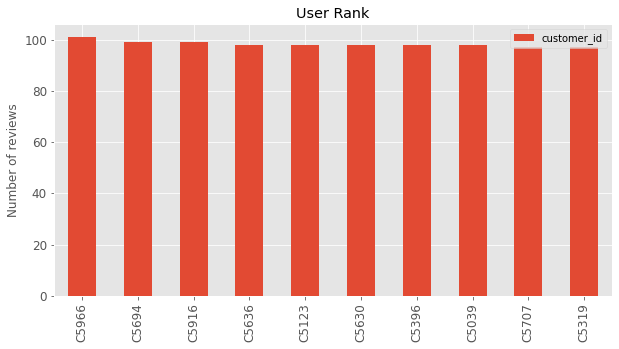

In [16]:
user_top_10 = df1.customer_id.value_counts()[:10]

plt.style.use('ggplot')
user_top_10.plot(kind = 'bar', title = 'User Rank',
                            figsize = (10, 5), legend = True, fontsize = 12)
plt.ylabel("Number of reviews", fontsize = 12)
plt.show()

#### (3) 유저들로 부터 평점을 많이 받은 영화 TOP 10

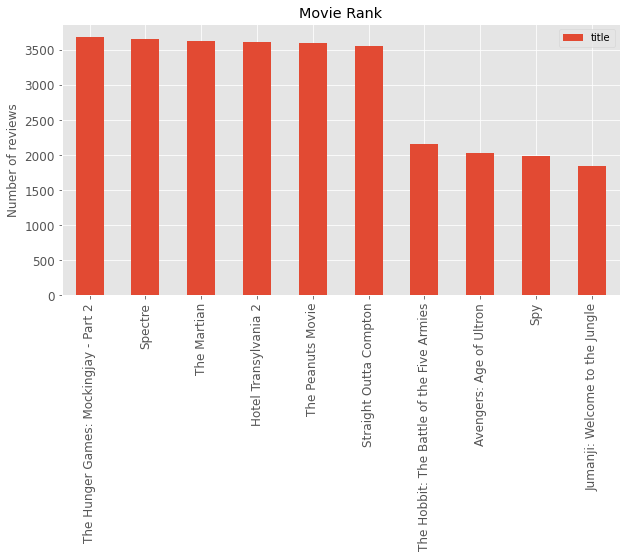

In [17]:
# matplotlib에서 한글 사용

movie_top_10 = df1.title.value_counts()[:10]

plt.style.use('ggplot')
movie_top_10.plot(kind = 'bar', title = 'Movie Rank',
                            figsize = (10, 5), legend = True, fontsize = 12)
plt.ylabel("Number of reviews", fontsize = 12)
plt.show()

#### (4) Score 랭킹

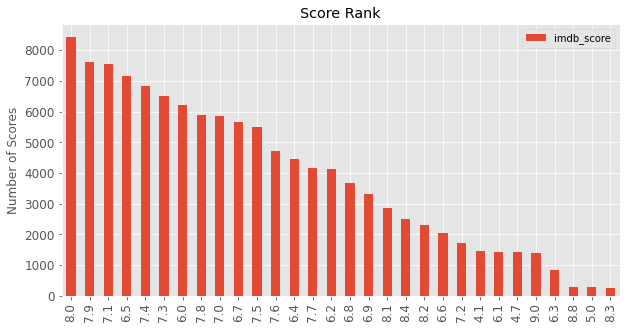

In [18]:
plt.style.use('ggplot')
df1.imdb_score.value_counts().plot(kind = 'bar', title = 'Score Rank',
                            figsize = (10, 5), legend = True, fontsize = 12)
plt.ylabel("Number of Scores", fontsize = 12)
plt.show()

## 4. 협업필터링을 이용한 영화 추천 알고리즘
다음과 같은 순서로 진행함
1. 계산을 용이하게 하기 위해 각 원소 ** $ a_{ij} $ ** 가 유저(i)가 영화(j)에 준 평점(score)을 의미하는 유틸리티행렬(U)를 만든다.
2. target 유저(t)의 number가 들어오면 코사인 유사도를 이용하여 각 사용자의 짝 유사도를 계산한다. 이를 이용하여 유저(t)와 가장 비슷한 유저(s) K명을 찾는다.
2. 유저(t)와 유사한 K명의 유저(s)들이 아이템에 대해 평가한 평점을 이용하여, 유저(t)가 아직 평가하지 않은 영화(j)의 평점을 예측한다. 이때, 유저(s)의 평점을 가중평균하여 계산한다.
3. 성능 평가를 통해 알맞은 K를 구한다.
4. 예측한 평점을 이용하여 유저(t)에게 영화 3편을 추천한다.

### I. 유틸리티행렬

#### (1) LabelEndoder를 이용하여 user와 title을 수치화 한다.

In [19]:
def execute_labeling(column_name):
    Lec = LabelEncoder()
    df_copy = df1.copy()
    df_label = pd.DataFrame(Lec.fit_transform(df_copy[column_name].values), columns = [column_name+'_label'])
    return df_label

df_user = execute_labeling('customer_id')
df_title = execute_labeling('title')
df_gender = execute_labeling('gender')
df_age_group = execute_labeling('age_group')
df_married = execute_labeling('married')
df_kids_under12 = execute_labeling('kids_under12')
df_Genre = execute_labeling('Genre_1')
df_country = execute_labeling('country_1')

print(len(df_user['customer_id_label'].value_counts()))
print(len(df_title['title_label'].value_counts()))
print(len(df_gender['gender_label'].value_counts()))
print(len(df_age_group['age_group_label'].value_counts()))
print(len(df_married['married_label'].value_counts()))
print(len(df_kids_under12['kids_under12_label'].value_counts()))
print(len(df_Genre['Genre_1_label'].value_counts()))
print(len(df_country['country_1_label'].value_counts()))

df_copy = df1.copy()    # copy df
df_copy = df_copy.drop(df_copy.columns[[0, 1, 2, 3, 4, 5, 7, 8]], axis = 1)    # delete 'user', 'title' columns
df_label = pd.concat([df_user, df_title, df_gender, df_age_group, df_married, df_kids_under12, df_Genre, df_country, df_copy], axis = 1)    # 라벨링한 컬럼과 기존 데이터프레임 합치기

df_label.tail(5)

3277
94
2
6
2
2
7
6


,customer_id_label,title_label,gender_label,age_group_label,married_label,kids_under12_label,Genre_1_label,country_1_label,imdb_score
116459,3276,12,1,2,1,0,2,5,6.3
116460,3276,33,1,2,1,0,6,5,7.4
116461,3276,53,1,2,1,0,0,5,7.5
116462,3276,83,1,2,1,0,0,5,7.9
116463,3276,67,1,2,1,0,4,5,7.7


In [20]:
!pip install scikit-learn-extra

In [21]:
from sklearn_extra.cluster import KMedoids

In [22]:
df = df_label[:50000]

In [23]:
df.columns

Index(['customer_id_label', 'title_label', 'gender_label', 'age_group_label',
       'married_label', 'kids_under12_label', 'Genre_1_label',
       'country_1_label', 'imdb_score'],
      dtype='object')

In [ ]:
n_iter = 15
cluster_range = [i+1 for i in range(n_iter)]
clus_error = []

for v in cluster_range:
    clus = KMedoids(n_clusters=v)
    clus.fit(df[['customer_id_label', 'title_label', 'gender_label', 'age_group_label',
       'married_label', 'kids_under12_label', 'Genre_1_label',
       'country_1_label', 'imdb_score']])
    clus_error.append(clus.inertia_)

ds_error = pd.DataFrame({'NumberofCluster':cluster_range,
                       'Error':clus_error})
ds_error

/home/piai/anaconda3/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
plt.plot(ds_error['NumberofCluster'], ds_error['Error'])
plt.title('Sum of squared distance')

In [ ]:
clus = KMedoids(11)
clus.fit(df[['customer_id_label', 'title_label', 'gender_label', 'age_group_label',
   'married_label', 'kids_under12_label', 'Genre_1_label',
   'country_1_label', 'imdb_score']])

cluster_kmeans = [i+1 for i in clus.labels_]
inventory["ClusterKmeans"] = cluster_kmeans
inventory.head()